Here is where we create a model. In this case we take in CleanedSpy.csv, which is data only from SPY. It is run through dataWrangling, and then run here. The basic goal of this file is to create a RandomForestRegressor model from mlflow.sklearn. We also take advantage of timeseriescv, which models Marcos Prado's method for a train/test split of the data. Essentially, we make sure to purge any data which is placed in the train set, but the model is asked to predict on data found in the test set. Since we are currently running with 1M candlestick data, this only deletes a very small number of points, but would prove very useful for larger time frames to prevent overfitting.

In [3]:
#Prep pandas df for timeseriescv
import pandas as pd
pdDf=pd.read_csv("CleanedSpy.csv",index_col=0)
pdDf=pdDf.rename(columns={"Time": "pred_times"})
pdDf['eval_times']=pdDf['pred_times']+60;#Change to 300 for 5 min for example

display(pdDf)

,Ticker,pred_times,Volume,logChange,label,prev1,prev2,prev3,prev4,prevVol1,prevVol2,prevVol3,prevVol4,eval_times
0,1,1562170800,117422.0,-0.000101,-0.000168,-0.000134,0.000202,-0.000403,0.000000,50947.0,9238.0,12661.0,100.0,1562170860
1,1,1562171520,1000.0,-0.000168,0.000269,-0.000101,-0.000134,0.000202,-0.000403,117422.0,50947.0,9238.0,12661.0,1562171580
2,1,1562172240,3308.0,0.000269,0.000067,-0.000168,-0.000101,-0.000134,0.000202,1000.0,117422.0,50947.0,9238.0,1562172300
3,1,1562172960,690.0,0.000067,-0.000168,0.000269,-0.000168,-0.000101,-0.000134,3308.0,1000.0,117422.0,50947.0,1562173020
4,1,1562173620,8819.0,-0.000168,-0.000504,0.000067,0.000269,-0.000168,-0.000101,690.0,3308.0,1000.0,117422.0,1562173680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118173,1,1592870040,284753.0,-0.000451,0.000773,0.000515,0.000661,-0.000193,0.000403,525818.0,283778.0,209723.0,657198.0,1592870100
118174,1,1592870100,399185.0,0.000773,0.000169,-0.000451,0.000515,0.000661,-0.000193,284753.0,525818.0,283778.0,209723.0,1592870160
118175,1,1592870160,466966.0,0.000169,-0.000072,0.000773,-0.000451,0.000515,0.000661,399185.0,284753.0,525818.0,283778.0,1592870220
118176,1,1592870220,471539.0,-0.000072,-0.000064,0.000169,0.000773,-0.000451,0.000515,466966.0,399185.0,284753.0,525818.0,1592870280


In [4]:
#USING MLFLOW library instead
from timeseriescv import cross_validation as cv
from sklearn.model_selection import train_test_split
from itertools import tee

train, test=train_test_split(pdDf, test_size=0.2, shuffle=False)
splits=8
crossval=cv.PurgedWalkForwardCV(n_splits=splits+2) #Default settings: n_splits=10, n_test_splits=1, min_train_splits=2, max_train_splits=None
crossval=crossval.split(train, train['label'],train['pred_times'],train['eval_times'],False)
#True above means identical time intervals as opposed to identical sample splits
crossval,crossval_backup=tee(crossval)

In [5]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3,4,5,6],
    'max_features': [8,10,11],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10,12],
    'n_estimators': [100,200,300,1000]
}


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Create a based model
rf = RandomForestRegressor(random_state=1)
# Instantiate the grid search model
rndm_search = RandomizedSearchCV(
    estimator = rf, param_distributions = param_grid, n_iter=20,cv = crossval, scoring='r2', n_jobs = -1)

In [7]:
#Create a evaluation function
import numpy as np
from sklearn.metrics import r2_score
def evaluate(model, test_features, test_labels):
        predictions = model.predict(test_features)
        r2=r2_score(test_labels, predictions)
        print('Model Performance')
        print('r2: {:0.4f}.'.format(r2))
        return r2

In [8]:
import joblib 
from dask.distributed import Client, progress
client = Client()
#Use dask to parallelize the fit process, and 
with joblib.parallel_backend('dask'):
    rndm_search.fit(train[['Ticker','Volume','prevVol1','prevVol2','prevVol3','prevVol4',
                          'logChange','prev1','prev2','prev3','prev4']],train['label'])

In [22]:
import pandas as pd
pd.DataFrame(rndm_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,...,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,275.673776,14.325535,0.125915,0.052909,300,8,5,8,6,False,...,-0.106508,-0.024332,-0.006632,-0.093335,-0.045470,0.004838,-0.017478,-0.047641,0.040977,16
1,89.464901,14.077462,0.048406,0.005016,100,10,5,10,5,False,...,-0.089053,-0.026138,-0.008275,-0.089342,-0.058211,-0.006675,-0.017446,-0.048579,0.035817,17
2,181.710030,33.694278,0.124204,0.131861,200,10,3,10,6,True,...,-0.029406,-0.022136,-0.005441,-0.076147,-0.012086,0.009580,-0.009377,-0.025483,0.026872,9
3,566.466896,152.833603,0.352818,0.025800,1000,10,3,11,5,True,...,-0.029351,-0.017725,-0.000694,-0.078030,-0.010320,0.009470,-0.010652,-0.023671,0.026932,8
4,568.150436,144.463303,0.415001,0.240473,1000,10,4,8,3,False,...,-0.067500,-0.013472,-0.001169,-0.091332,-0.006212,0.014867,-0.020766,-0.036182,0.041964,12


In [23]:
print("Best parameters: ")
print(rndm_search.best_params_)
best_grid = rndm_search.best_estimator_
print("\nTest")
grid_accuracy = evaluate(best_grid, test[['Ticker','Volume','prevVol1','prevVol2','prevVol3','prevVol4',
                          'logChange','prev1','prev2','prev3','prev4']], test['label'])
print("\nTrain")
grid_accuracy = evaluate(best_grid, train[['Ticker','Volume','prevVol1','prevVol2','prevVol3','prevVol4',
                          'logChange','prev1','prev2','prev3','prev4']], train['label'])

Best parameters: 
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 11, 'max_depth': 3, 'bootstrap': True}

Test
Model Performance
r2: -0.0025.

Train
Model Performance
r2: 0.0284.


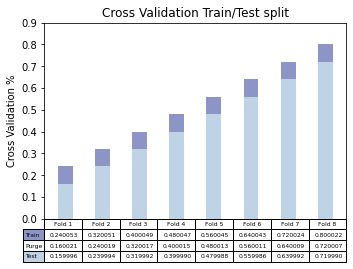

In [24]:
import matplotlib.pyplot as plt

#Obtain matrix with rows = fold #, cols=train/test, 
data=[]
for i in range(splits):
    train_temp,test_temp=next(crossval_backup)
    data.append([train_temp[-1]/len(pdDf),(test_temp[1]-train_temp[-1])/len(pdDf),test_temp[-1]/len(pdDf)])
#Need to take transpose of data
data=list(map(list,zip(*data)))
#Need to subtract training from test
import operator
data[2]=list(map(operator.sub, data[2], data[0]))
data[2]=list(map(operator.add, data[2], data[1]))

rows=('Train','Purge','Test')
columns=['Fold %d'%x for x in range(1,splits+1)]
#columns.append("Holdout")
values=np.arange(0,1,0.1)

colors = plt.cm.BuPu([0.25,0,0.5])
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1f' % x for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel("Cross Validation %")
plt.yticks(values, ['%1.1f' % val for val in values])
plt.xticks([])
plt.title('Cross Validation Train/Test split')

plt.show()

In [21]:
#Export the model
import pickle
pkl_filename = "myModel.cpickle"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rndm_search.best_estimator_, file)

In [27]:
#Example of how to import the model
import cloudpickle as cp
from urllib.request import urlopen
model = cp.load(urlopen("https://raw.githubusercontent.com/grantjensen/Backtesting2/master/myModel.cpickle"))

In [30]:
#Example prediction
model.predict([[1, 73240, 76141, 132351, 111472, 91095, -0.0001976145111942757, -0.000761861801266224, 0.00047962308188520823, 0.0004798532305751543, 0.0004518370074894487]])

array([-1.80409709e-05])